# **ETL/EDA** user_items

Aquí mostramos los pasos que hemos seguido para la limpieza, tratamiento y exploración de los datos, para el dataset USER_ITEMS el resultado de este procedimiento es 1 archivo tratado, que luego es cargado y re-procesado posteriormente en la construcción de las soluciones a los problemas planteados.

In [15]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
import seaborn as sns

Carga del dataset 'australian_users_items.json'

In [1]:
# El siguiente codigo nos permite detectar encoding
import chardet

file_path = 'australian_users_items.json'
chunk_size = 1024  # Adjust the chunk size based on your file characteristics

with open(file_path, 'rb') as f:
    detector = chardet.universaldetector.UniversalDetector()
    while True:
        chunk = f.read(chunk_size)
        if not chunk:
            break
        detector.feed(chunk)
        if detector.done:
            break
    detector.close()

result = detector.result

encoding = result['encoding']
confidence = result['confidence']

print(f"Detected encoding: {encoding} (Confidence: {confidence:.2f})")

Detected encoding: utf-8 (Confidence: 0.99)


In [5]:
input_file = 'australian_users_items.json'

# Leer el contenido del archivo JSON
with open(input_file, 'r', encoding='utf-8') as f:
    data = f.read()

# Convertir las líneas a registros JSON
records = [eval(line.strip()) for line in data.split('\n') if line.strip()]

# Crear el DataFrame a partir de los registros
dfitems = pd.DataFrame(records)
dfitems.head()

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


Desempacamos Json anidados

In [6]:
desem = dfitems.apply(lambda row: [{'user_id': row['user_id'],  'items_count': row['items_count'], 'steam_id': row['steam_id'], 'user_url': row['user_url'], **item} for item in row['items']], axis=1)

df_items = pd.DataFrame([item for sublist in desem for item in sublist])
df_items.head()

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6,0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0,0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7,0
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0,0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0,0


## Limpieza de los datos

### Exploración

In [7]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5153209 entries, 0 to 5153208
Data columns (total 8 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_id           object
 1   items_count       int64 
 2   steam_id          object
 3   user_url          object
 4   item_id           object
 5   item_name         object
 6   playtime_forever  int64 
 7   playtime_2weeks   int64 
dtypes: int64(3), object(5)
memory usage: 314.5+ MB


Contamos los valores Nan y vacios

In [8]:
nan_counts = df_items.isna().sum()

nan_counts

user_id             0
items_count         0
steam_id            0
user_url            0
item_id             0
item_name           0
playtime_forever    0
playtime_2weeks     0
dtype: int64

In [9]:
empty_counts = df_items.applymap(lambda x: x == '').sum()
empty_counts

user_id             0
items_count         0
steam_id            0
user_url            0
item_id             0
item_name           0
playtime_forever    0
playtime_2weeks     0
dtype: int64

Verificamos valores anómalos en todas las columnas pero se verifico que los datos estan correctos:

In [10]:
df_items["user_url"].sort_values( inplace=False, ascending=False)

5153208    http://steamcommunity.com/profiles/76561198329...
5153207    http://steamcommunity.com/profiles/76561198329...
5153206    http://steamcommunity.com/profiles/76561198329...
5153205    http://steamcommunity.com/profiles/76561198329...
5153204    http://steamcommunity.com/profiles/76561198329...
                                 ...                        
1808424                 http://steamcommunity.com/id/--000--
1808426                 http://steamcommunity.com/id/--000--
1808427                 http://steamcommunity.com/id/--000--
1808428                 http://steamcommunity.com/id/--000--
1808455                 http://steamcommunity.com/id/--000--
Name: user_url, Length: 5153209, dtype: object

Eliminamos filas duplicadas y resetamos el índice

In [11]:
df_items.drop_duplicates(inplace=True)
df_items.reset_index(drop=True, inplace=True)

In [12]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094105 entries, 0 to 5094104
Data columns (total 8 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_id           object
 1   items_count       int64 
 2   steam_id          object
 3   user_url          object
 4   item_id           object
 5   item_name         object
 6   playtime_forever  int64 
 7   playtime_2weeks   int64 
dtypes: int64(3), object(5)
memory usage: 310.9+ MB


Visualizamos el comportamiento del tiempo de juego en minutos, la mayoria de los datos se agrupan entre 0 y 400000 minutos de juego total

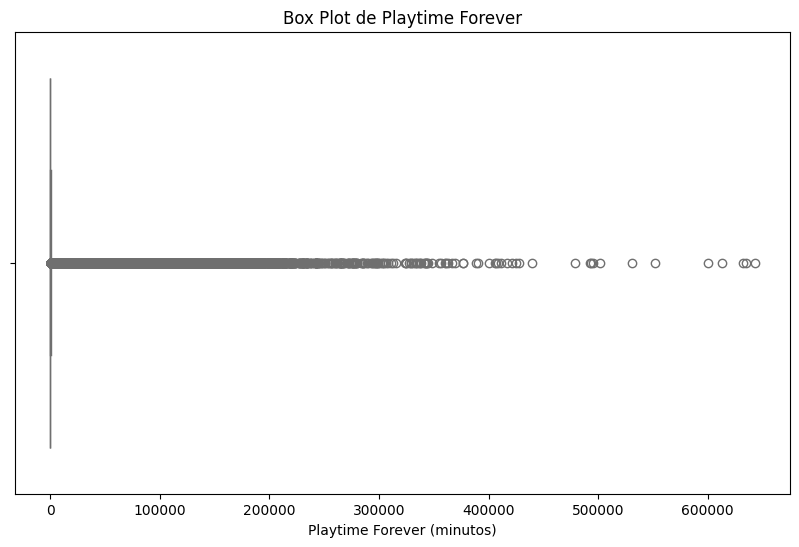

In [19]:

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_items['playtime_forever'], color='skyblue')

# Personalizar el gráfico
plt.title('Box Plot de Playtime Forever')
plt.xlabel('Playtime Forever (minutos)')

# Mostrar el box plot
plt.show()

Guardamos el dataframe en un CSV para poder utilizarlo posteriormente.

In [13]:
df_items.to_csv('items.csv')